In [1]:
import Bayes
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Bayes import generate_toy_data
from Bayes import analyze_uncertainty_by_region
from Bayes.models import BayesianRegressor
from Bayes.utils import (
    BayesianRegressionTrainer,
    plot_1d_regression_with_uncertainty,
    plot_predictions
)

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

Generating synthetic data...

Training the model...
Epoch 1/1000, Train Loss: 1262.9574
Epoch 100/1000, Train Loss: 125.8258
Epoch 200/1000, Train Loss: 54.1900
Epoch 300/1000, Train Loss: 30.2099
Epoch 400/1000, Train Loss: 23.4206
Epoch 500/1000, Train Loss: 19.6231
Epoch 600/1000, Train Loss: 17.2923
Epoch 700/1000, Train Loss: 15.3114
Epoch 800/1000, Train Loss: 14.5140
Epoch 900/1000, Train Loss: 14.0617
Epoch 1000/1000, Train Loss: 13.0981


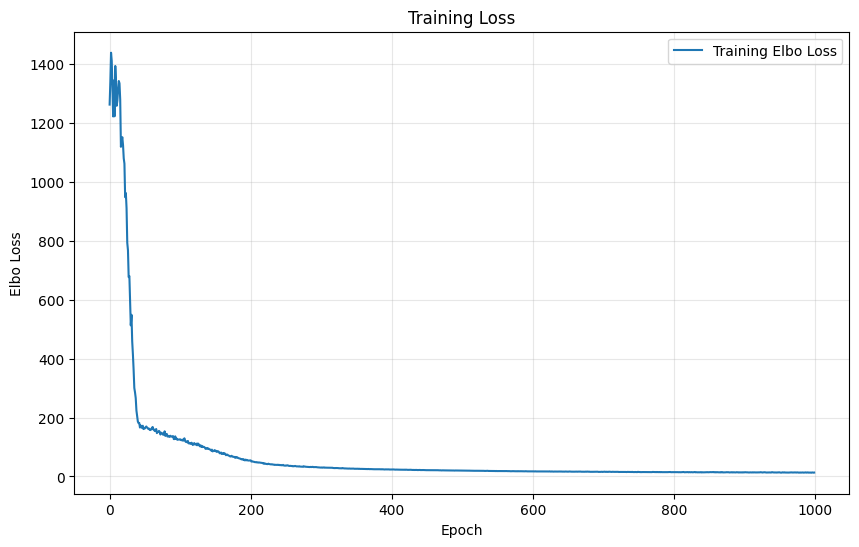

In [3]:
# Generate synthetic data
print("Generating synthetic data...")
X, y = generate_toy_data(n_samples=300, noise_level=0.5, test_gaps=True)
    
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)
    
model = BayesianRegressor(input_dim=1, hidden_dims=[32, 32], output_dim=1)
    
# Create a trainer
trainer = BayesianRegressionTrainer(
          model=model,
          learning_rate=0.001
    )
    
# Train the model
print("\nTraining the model...")
train_losses, val_losses = trainer.train(
        X_train=X_train_tensor, 
        y_train=y_train_tensor,
        batch_size=32,
        epochs=1000,
        samples_nbr=5
        )
    
# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Elbo Loss')
plt.xlabel('Epoch')
plt.ylabel('Elbo Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
   

<h1>BNN prefer to be uncertainty while there is no data whlist traditional NN might be overly confident.<h1>
    
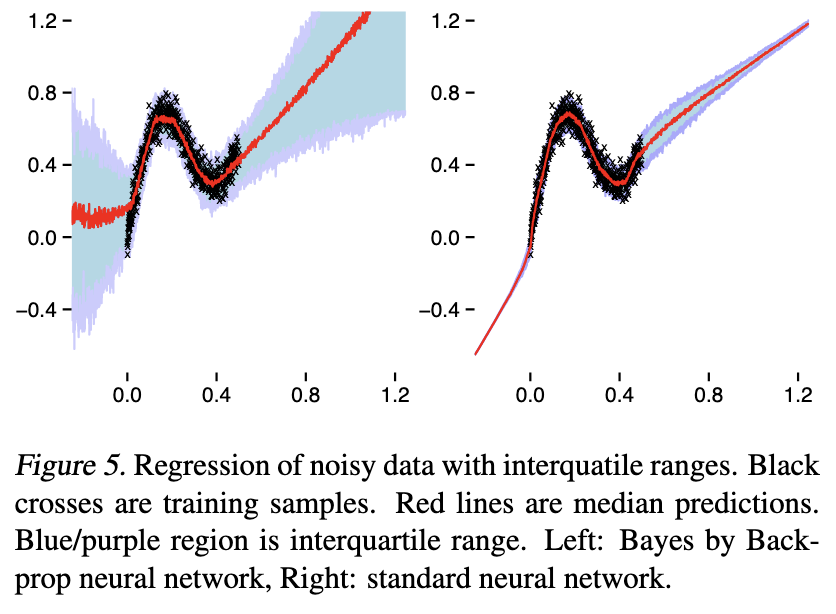
    


<h2>Our experimental result also well fit the effect with the paper "Weight uncertainty on Neuron Network"

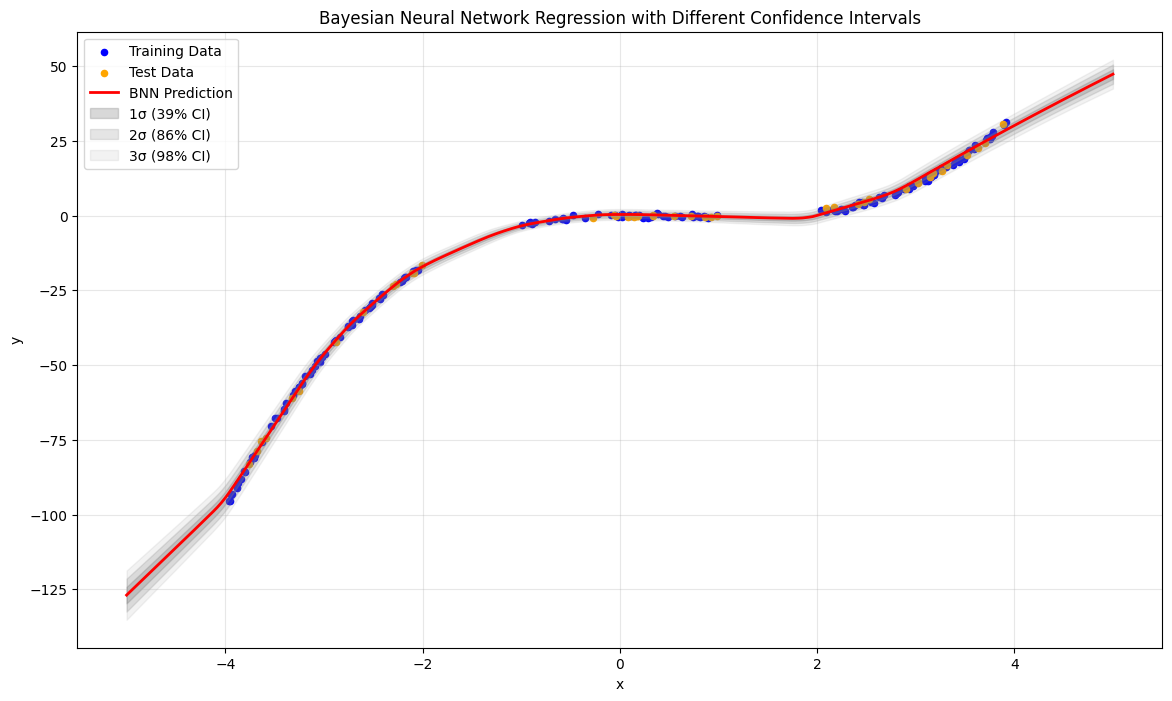

In [4]:
# Create a dense grid of points for visualization
X_dense = np.linspace(-5, 5, 500).reshape(-1, 1)
X_dense_tensor = torch.FloatTensor(X_dense)
    
# Make predictions with uncertainty
y_pred_mean, y_pred_std, _ = trainer.predict(X_dense_tensor, num_samples=100)
  
# Plot the results
plot_1d_regression_with_uncertainty(
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        X_dense=X_dense, 
        y_pred_mean=y_pred_mean, 
        y_pred_std=y_pred_std
    )

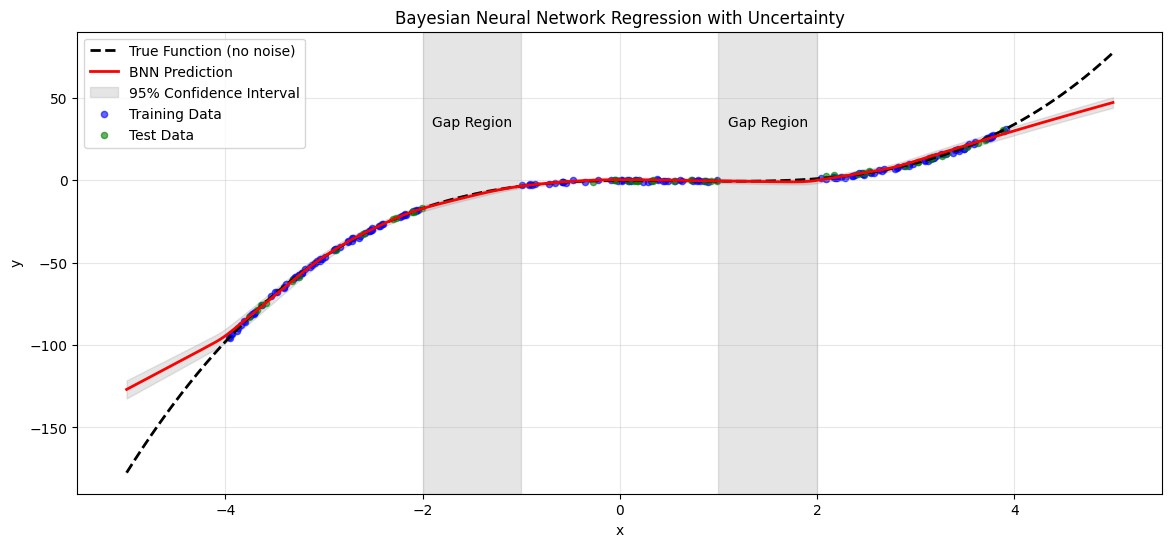

In [7]:
# Plot true function without noise
X_true = np.linspace(-5, 5, 500)
y_true = X_true**3 - 2 * X_true**2 + 0.5 * X_true
    
plt.figure(figsize=(14, 6))
plt.plot(X_true, y_true, 'k--', lw=2, label='True Function (no noise)')
plt.plot(X_dense, y_pred_mean, 'r-', lw=2, label='BNN Prediction')
plt.fill_between(
        X_dense.flatten(), 
        (y_pred_mean - 2 * y_pred_std).flatten(), 
        (y_pred_mean + 2 * y_pred_std).flatten(), 
        color='gray', alpha=0.2, label='95% Confidence Interval'
    )
plt.scatter(X_train, y_train, c='blue', s=20, alpha=0.6, label='Training Data')
plt.scatter(X_test, y_test, c='green', s=20, alpha=0.6, label='Test Data')
    
# Highlight the gap regions
plt.axvspan(-2, -1, color='gray', alpha=0.2)
plt.axvspan(1, 2, color='gray', alpha=0.2)
plt.text(-1.5, max(y_train), 'Gap Region', ha='center', va='bottom')
plt.text(1.5, max(y_train), 'Gap Region', ha='center', va='bottom')
    
plt.title('Bayesian Neural Network Regression with Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

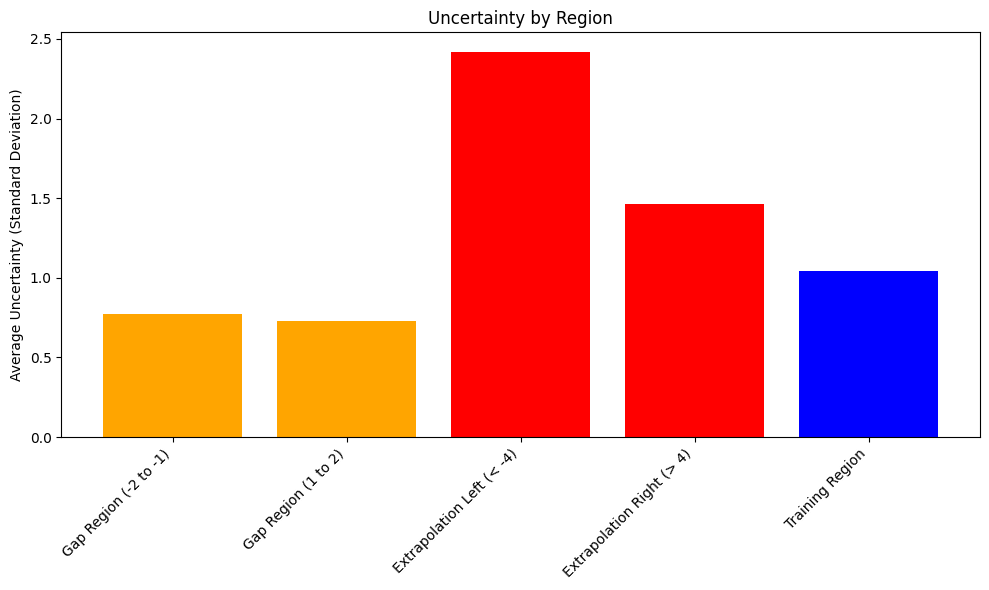

Average uncertainty by region:
Gap Region (-2 to -1): 0.7728
Gap Region (1 to 2): 0.7283
Extrapolation Left (< -4): 2.4200
Extrapolation Right (> 4): 1.4657
Training Region: 1.0418


In [6]:
# Analyze uncertainty in different regions
analyze_uncertainty_by_region(X_dense, y_pred_std)